In [23]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from trajectory import rat_trajectory
from scipy.interpolate import interp1d

#Perameters
shape = 'Sqr'

spk_filename = f'data/B6_8_1_{shape}_Spike.csv'
trc_filename = f'data/B6_8_1_{shape}_Trace.csv'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
trace_per_cell = {cell: [] for cell in cell_numbers}
spike_times = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[2:, 0].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory(shape)


# get trace data from each cell + interpolate
for i in range(np.shape(df.iloc[2:])[1] - 1):
    cell_name = np.asarray(cell_numbers)[i]
    trace_data = [float(i) for i in df.iloc[2:, i+1].tolist()]
    time_interp = interp1d(time_data, trace_data)

    trace_data = time_interp(traj_time)
    trace_data = trace_data / np.max(trace_data) * 2
    trace_per_cell[cell_name] = trace_data.tolist()

# get spike data from each cell + interpolate
with open(spk_filename, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        time = float(row[0]) - start_time
        cell = row[1]
        if cell in spike_times:
            spike_times[cell].append(time)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp

# discard index where velocity < threshold
threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > threshold]


In [25]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

# Get spike data -> nearest interpolation
spiking_data = np.zeros((len(traj_time), len(cell_numbers)))

for i, cell in enumerate(cell_numbers):
    for spike_time in spike_times[cell]:
        nearest_index = find_nearest_time_index(spike_time, traj_time)
        if nearest_index in moving_idx:
            spiking_data[nearest_index, i] = 1

# Get trace data
total_trace = np.zeros((len(traj_time), len(cell_numbers)))

for i, cell in enumerate(cell_numbers):
    total_trace[:, i] = np.asarray(trace_per_cell[cell])

/tmp/ipykernel_17963/1478205632.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cell_x, cell_y, c=colors/255, cmap='viridis')


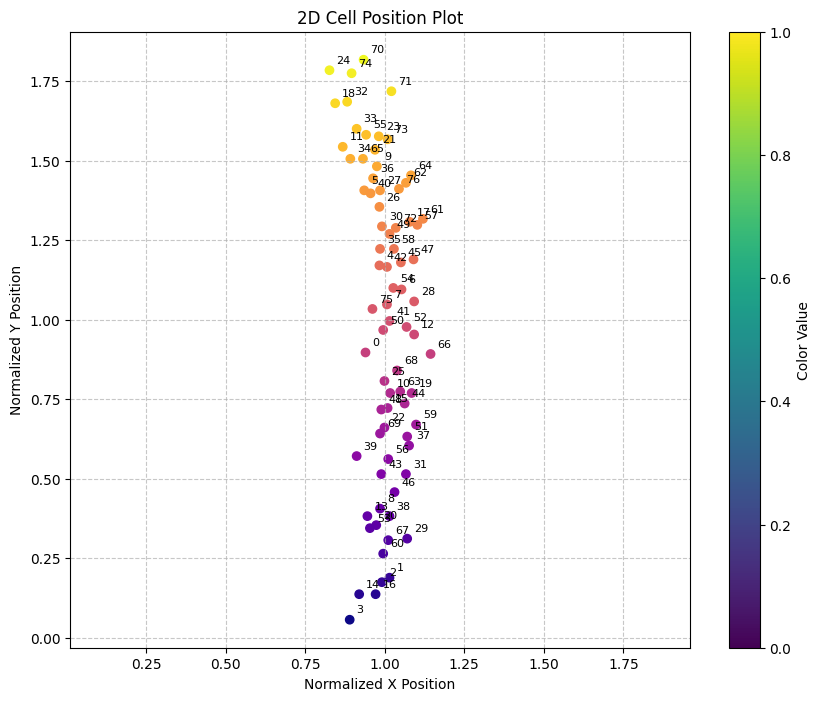

In [26]:
## drawing real cell geometry data

cell_filename = f'data/B6_8_1_{shape}_Trace-props.csv'

# Read the CSV file
df = pd.read_csv(cell_filename, header=None)

# Get cell numbers
cell_x = [float(i) for i in df.iloc[1:, 5]]
cell_y = [float(i) for i in df.iloc[1:, 6]]

cell_x = cell_x / np.mean(cell_x)
cell_y = cell_y / np.mean(cell_y)

norm = plt.Normalize(cell_y.min(), cell_y.max())
normalized_index = norm(cell_y)

cmap = plt.get_cmap('plasma')  # or 'viridis'

colors_float = cmap(normalized_index)[:, :3]
colors = (colors_float * 255).astype(int)

plt.figure(figsize=(10, 8))
plt.scatter(cell_x, cell_y, c=colors/255, cmap='viridis')
plt.colorbar(label='Color Value')

# Add indices as annotations
for i, (x, y) in enumerate(zip(cell_x, cell_y)):
    plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('2D Cell Position Plot')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'Figures-cebra/{shape}-cell-position')
plt.show()

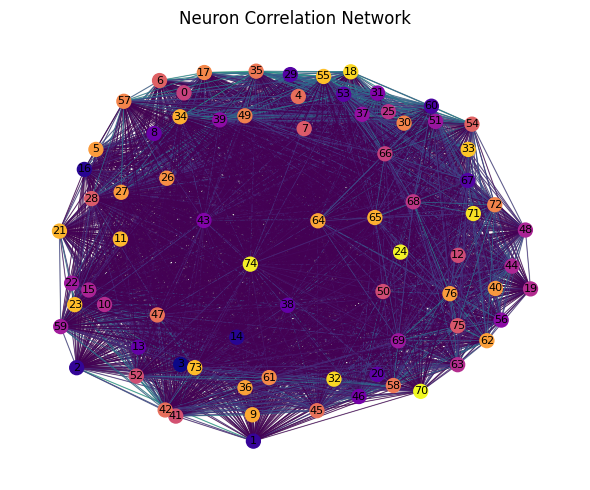

Top 10 highest correlations:
Neurons 37 and 51: 0.663
Neurons 17 and 35: 0.618
Neurons 10 and 15: 0.594
Neurons 30 and 37: 0.593
Neurons 1 and 2: 0.571
Neurons 25 and 30: 0.564
Neurons 41 and 42: 0.554
Neurons 30 and 55: 0.553
Neurons 34 and 35: 0.549
Neurons 18 and 37: 0.543


In [27]:
import networkx as nx
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from umap import UMAP

# Assuming spiking_data and total_trace are already defined as per your code
# using_data = spiking_data
# data_type = "spikes"
# threshold = 0.1

using_data = total_trace
data_type = "trace"
threshold = 0.3

# Step 1: Calculate correlation matrix
def calculate_correlation_matrix(data):
    num_neurons = data.shape[1]
    corr_matrix = np.zeros((num_neurons, num_neurons))
    for i in range(num_neurons):
        for j in range(i, num_neurons):
            corr, _ = pearsonr(data[:, i], data[:, j])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr
    return corr_matrix

# Calculate correlation based on spiking data
spike_corr_matrix = calculate_correlation_matrix(using_data)

# Step 2: Create a network graph
G = nx.Graph()
num_neurons = spike_corr_matrix.shape[0]

for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        if spike_corr_matrix[i, j] > threshold or spike_corr_matrix[i, j] < threshold:  # You can adjust this threshold
            G.add_edge(i, j, weight=spike_corr_matrix[i, j])

# Step 3: Use Multidimensional Scaling (MDS) to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - spike_corr_matrix  # Convert correlations to distances
positions = mds.fit_transform(distances)

node_colors = colors_float[G.nodes()]

# Step 4: Visualize the network
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G, positions, node_size=100, node_color=node_colors)
nx.draw_networkx_edges(G, positions, alpha=0.2)
nx.draw_networkx_labels(G, positions, font_size=8)

# Add colorbar to show correlation strength
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, positions, edge_color=edge_colors, width=0.5, 
                               edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1)

plt.title('Neuron Correlation Network')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/{shape}_{data_type}_network_2d')
plt.show()

# Step 5: Print highest correlations
top_correlations = []
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        top_correlations.append((i, j, spike_corr_matrix[i, j]))

top_correlations.sort(key=lambda x: x[2], reverse=True)
print("Top 10 highest correlations:")
for i, j, corr in top_correlations[:10]:
    print(f"Neurons {i} and {j}: {corr:.3f}")

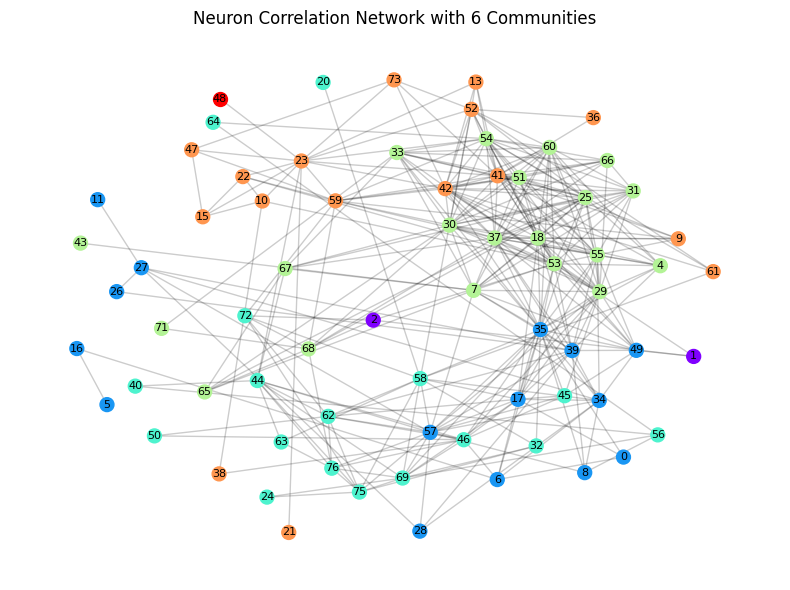

Community 1 indices: [1, 2]
Community 2 indices: [0, 5, 6, 8, 11, 16, 17, 26, 27, 28, 34, 35, 39, 49, 57]
Community 3 indices: [20, 24, 32, 40, 44, 45, 46, 50, 56, 58, 62, 63, 64, 69, 72, 75, 76]
Community 4 indices: [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67, 68, 71]
Community 5 indices: [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]
Community 6 indices: [48]

Top 3 largest communities:
Community 1 indices: [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67, 68, 71]
Community 2 indices: [20, 24, 32, 40, 44, 45, 46, 50, 56, 58, 62, 63, 64, 69, 72, 75, 76]
Community 3 indices: [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]


In [28]:
import networkx as nx
from scipy.stats import pearsonr
from sklearn.manifold import MDS

# Step 1: Calculate correlation matrix
def calculate_correlation_matrix(data):
    num_neurons = data.shape[1]
    corr_matrix = np.zeros((num_neurons, num_neurons))
    for i in range(num_neurons):
        for j in range(i, num_neurons):
            corr, _ = pearsonr(data[:, i], data[:, j])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr
    return corr_matrix

# Calculate correlation based on spiking data
spike_corr_matrix = calculate_correlation_matrix(using_data)

# Create the graph
threshold = 0.3
G = nx.Graph()
num_neurons = spike_corr_matrix.shape[0]
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        if abs(spike_corr_matrix[i, j]) > threshold:
            G.add_edge(i, j, weight=spike_corr_matrix[i, j])

# Use MDS to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - np.abs(spike_corr_matrix)  # Convert correlations to distances
positions = mds.fit_transform(distances)

# Use Louvain community detection
communities = list(nx.community.louvain_communities(G))

# Visualize the network with community colors
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, positions, nodelist=community, node_color=[colors[i]] * len(community), node_size=100)
nx.draw_networkx_edges(G, positions, alpha=0.2)
nx.draw_networkx_labels(G, positions, font_size=8)

plt.title(f'Neuron Correlation Network with {len(communities)} Communities')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/network-communities_{shape}_{data_type}.png')
plt.show()

# Print community indices
for i, community in enumerate(communities):
    print(f"Community {i+1} indices: {sorted(community)}")

# If you specifically want 3 main communities, you can sort and select the top 3 by size
top_3_communities = sorted(communities, key=len, reverse=True)[:3]

print("\nTop 3 largest communities:")
for i, community in enumerate(top_3_communities):
    print(f"Community {i+1} indices: {sorted(community)}")

In [29]:
from umap import UMAP
import open3d as o3d

colors_float = cmap(normalized_index)[:, :3]
colors = (colors_float * 255).astype(int)

umap = UMAP(n_components=3, metric='precomputed', random_state=42)
distances = 1 - spike_corr_matrix   # Convert correlations to distances
positions_3d = umap.fit_transform(distances)

avg_correlations = np.mean(spike_corr_matrix, axis=1)
min_corr, max_corr = np.min(avg_correlations), np.max(avg_correlations)
# colors = (avg_correlations - min_corr) / (max_corr - min_corr)  # Normalize to [0, 1]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(positions_3d)
pcd.colors = o3d.utility.Vector3dVector(colors_float)  # RGB

o3d.io.write_point_cloud(f"Network_3d_structure/{shape}_{data_type}_network_3d.ply", pcd)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


True

In [30]:
from sklearn.preprocessing import StandardScaler

# Step 1: Preprocess the data
scaler = StandardScaler()
spiking_data_scaled = scaler.fit_transform(using_data)

# Step 2: Apply UMAP
umap = UMAP(n_components=3, 
            metric='correlation',  # Use correlation as the metric
            random_state=42)
positions_3d = umap.fit_transform(spiking_data_scaled.T)  # Transpose to get (n_neurons, n_timesteps)

# Step 3: Create color map (assuming 'colors_float' defined as before)

# Step 4: Create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(positions_3d)
pcd.colors = o3d.utility.Vector3dVector(colors_float)  # RGB

# Step 5: Save as PLY file
o3d.io.write_point_cloud(f"Network_3d_structure/UMAP_{shape}_{data_type}_network_3d.ply", pcd)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


True

In [31]:
#### calculating temporal correlations ####

def time_lagged_correlation(x, y, max_lag):
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr, _ = pearsonr(x[-lag:], y[:lag])
        elif lag > 0:
            corr, _ = pearsonr(x[:-lag], y[lag:])
        else:
            corr, _ = pearsonr(x, y)
        corrs.append(corr)
    return np.array(corrs)


# Step 1: Compute time-lagged correlation matrix
max_lag = 10 
n_neurons = using_data.shape[1]
corr_matrix = np.zeros((n_neurons, n_neurons, 2*max_lag + 1))

for i in range(n_neurons):
    for j in range(n_neurons):
        corr_matrix[i, j] = time_lagged_correlation(using_data[:, i], using_data[:, j], max_lag)

# Flatten the correlation matrix
flattened_corr_matrix = corr_matrix.reshape(n_neurons, -1)

# Step 2: Apply UMAP
umap = UMAP(n_components=3, 
            metric='euclidean',
            random_state=42)
positions_3d = umap.fit_transform(flattened_corr_matrix)

# Step 3: Create color map based on maximum correlation (including time lags)
# max_correlations = np.max(np.abs(corr_matrix), axis=(1, 2))
# colors_float = plt.cm.viridis(max_correlations)[:, :3]
colors_float = cmap(normalized_index)[:, :3]

# Step 4: Create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(positions_3d)
pcd.colors = o3d.utility.Vector3dVector(colors_float)  # RGB

# Step 5: Save as PLY file
o3d.io.write_point_cloud(f"Network_3d_structure/time_lagged_{shape}_{data_type}_3d.ply", pcd)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


True

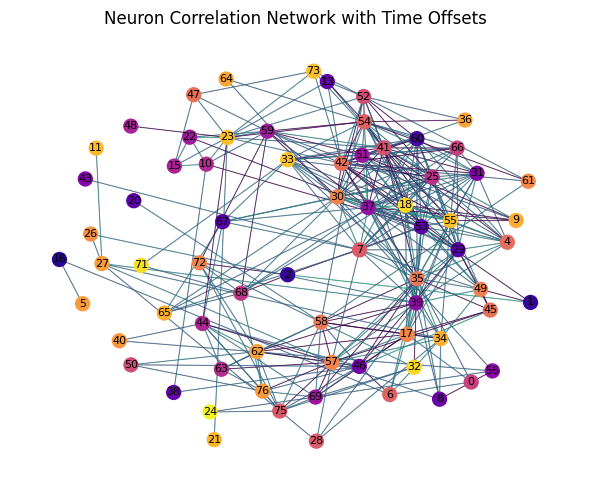

Top 10 highest correlations:
Neurons 37 and 51: 0.666
Neurons 17 and 35: 0.619
Neurons 10 and 15: 0.595
Neurons 30 and 37: 0.594
Neurons 1 and 2: 0.571
Neurons 30 and 55: 0.570
Neurons 25 and 30: 0.566
Neurons 18 and 37: 0.555
Neurons 41 and 42: 0.554
Neurons 34 and 35: 0.549


In [40]:
# Assuming corr_matrix is your 3D correlation matrix with shape (num_neurons, num_neurons, num_lags)

# Step 1: Prepare data
num_neurons = corr_matrix.shape[0]
num_lags = corr_matrix.shape[2]

# Step 2: Create a network graph
G2 = nx.Graph()
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        max_corr = np.max(np.abs(corr_matrix[i, j]))
        max_idx = np.argmax(np.abs(corr_matrix[i, j]))
        if max_corr > 0.3:  # You can adjust this threshold
            G2.add_edge(i, j, weight=max_corr * np.sign(corr_matrix[i, j, max_idx]))

# Step 3: Use Multidimensional Scaling (MDS) to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
max_corr_matrix = np.max(np.abs(corr_matrix), axis=2)
distances = 1 - max_corr_matrix  # Convert max correlations to distances
positions = mds.fit_transform(distances)

# Assuming colors_float is defined elsewhere
node_colors = [colors_float[i] for i in G2.nodes()]

# Step 4: Visualize the network
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G2, positions, node_size=100, node_color=node_colors)
nx.draw_networkx_edges(G2, positions, alpha=0.2)
nx.draw_networkx_labels(G2, positions, font_size=8)

# Add colorbar to show correlation strength
edge_colors = [G2[u][v]['weight'] for u, v in G2.edges()]
edges = nx.draw_networkx_edges(G2, positions, edge_color=edge_colors, width=0.5,
                               edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1)

plt.title('Neuron Correlation Network with Time Offsets')
plt.axis('off')
plt.tight_layout()
plt.savefig('Figures-cebra/time_lagged_network_2d.png')
plt.show()

# Step 5: Print highest correlations
top_correlations = []
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        max_corr = np.max(np.abs(corr_matrix[i, j]))
        top_correlations.append((i, j, max_corr))

top_correlations.sort(key=lambda x: x[2], reverse=True)
print("Top 10 highest correlations:")
for i, j, corr in top_correlations[:10]:
    print(f"Neurons {i} and {j}: {corr:.3f}")

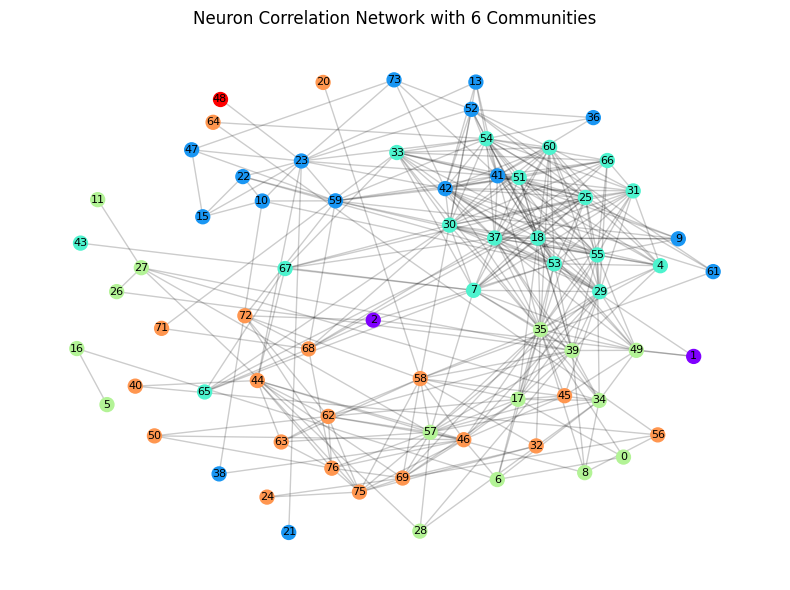

Community 1 indices: [1, 2]
Community 2 indices: [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]
Community 3 indices: [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67]
Community 4 indices: [0, 5, 6, 8, 11, 16, 17, 26, 27, 28, 34, 35, 39, 49, 57]
Community 5 indices: [20, 24, 32, 40, 44, 45, 46, 50, 56, 58, 62, 63, 64, 68, 69, 71, 72, 75, 76]
Community 6 indices: [48]

Top 3 largest communities:
Community 1 indices: [20, 24, 32, 40, 44, 45, 46, 50, 56, 58, 62, 63, 64, 68, 69, 71, 72, 75, 76]
Community 2 indices: [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67]
Community 3 indices: [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]


In [41]:
# Use MDS to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - np.abs(spike_corr_matrix)  # Convert correlations to distances
positions = mds.fit_transform(distances)

# Use Louvain community detection
communities = list(nx.community.louvain_communities(G2))

# Visualize the network with community colors
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G2, positions, nodelist=community, node_color=[colors[i]] * len(community), node_size=100)
nx.draw_networkx_edges(G2, positions, alpha=0.2)
nx.draw_networkx_labels(G2, positions, font_size=8)

plt.title(f'Neuron Correlation Network with {len(communities)} Communities')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/timelagged_network-communities_{shape}_{data_type}.png')
plt.show()

# Print community indices
for i, community in enumerate(communities):
    print(f"Community {i+1} indices: {sorted(community)}")

# If you specifically want 3 main communities, you can sort and select the top 3 by size
top_3_communities = sorted(communities, key=len, reverse=True)[:3]

print("\nTop 3 largest communities:")
for i, community in enumerate(top_3_communities):
    print(f"Community {i+1} indices: {sorted(community)}")